# Introduction For Agents


## 什么是智能体

一个能够进行推理、规划和与环境交互的人工智能模型。
我们称之为智能体，因为它具有能动性，即与环境交互的能力。
### 正式定义
智能体是一个系统，它利用人工智能模型与环境交互，以实现用户定义的目标。它结合推理、规划和动作执行（通常通过外部工具）来完成任务。
1. 大脑（AI Model）：AI模型**负责推理和规划**，它根据情况决定**采取哪些行动**
2. 身体（能力和tools）：代表智能体能做什么，**可能行动的范围**取决于智能体被**配备了什么**。
### AI 如何在环境中采取行动？
LLM 是令人惊叹的模型，但**它们只能生成文本**。

然而，如果你让像 HuggingChat 或 ChatGPT 这样的知名聊天应用程序生成图像，它们却可以做到！这是怎么可能的？

答案是，HuggingChat、ChatGPT 和类似应用程序的开发者实现了额外的功能（称为工具），LLM 可以利用这些工具来创建图像。
### 智能体可以执行什么类型的任务？
智能体可以通过**工具**执行我们实现的任何任务来完成**行动**。

例如，如果我编写一个智能体作为我电脑上的个人助理（像 Siri 一样），并且我让它“给我的经理发一封邮件，要求推迟今天的会议”，我可以给它一些发送邮件的代码。这将是一个新的工具，智能体在需要发送邮件时可以随时使用。我们可以用 Python 编写它：
```python
def send_message_to(recipient, message):
    """Useful to send an e-mail message to a recipient"""
    ...
```
如我们所见，大型语言模型（LLM）将在需要时生成运行该工具的代码，从而完成所需任务。

```python
send_message_to("Manager", "Can we postpone today's meeting?")
```
**工具的设计至关重要，对智能体的质量有着深远的影响**。某些任务可能需要定制特定的工具，而其他任务则可以通过通用工具（如“网络搜索”）来解决。

请注意，**动作（Actions）与工具（Tools）**是不同的概念。例如，一个动作可能涉及使用多个工具来完成任务。

### summary
总结而言，智能体是一个系统，它使用人工智能模型（通常是大语言模型）作为其核心推理引擎，以实现以下功能：

**理解自然语言**：以有意义的方式解释和回应人类指令。

**推理与规划**：分析信息、做出决策并制定解决问题的策略。

**与环境交互**：收集信息、执行操作并观察这些操作的结果。

## 什么是工具

AI Agent的关键能力在于执行**行动**，而执行行动是通过使用**工具**实现的。

### AI 工具的定义

**工具是赋予LLM的函数**，该函数实现 **明确的目标**

for examples:

* **网络搜索**：允许智能体从互联网获取最新的信息
* **图像生成**：根据文本描述生成图像
* **信息检索**：从外部信息源检索信息
* **API接口**：与外部API交互

优秀的工具应能**补充LLM的核心能力**，例如，若直接询问 LLM（无搜索工具）今日天气，LLM 可能会产生随机幻觉，但是如果定义一个可以访问天气API的工具供LLM使用，AI就能精确的告诉我们结果。

### 工具如何运作
正如前文所述，LLM 只能接**收文本输入并生成文本输出**。它们无法自行调用工具。当
我们谈及为智能体提供工具时，实质是**教导** LLM 认识工具的存在，并要求模型在需要
时生成调用工具的文本。例如，若我们提供从互联网获取某地天气的工具，当询问 
LLM 巴黎天气时，LLM 将识别该问题适合使用我们教授的”天气”工具，并生成代码形
式的文本来调用该工具。**智能体**负责解析 LLM 的输出，识别工具调用需求，并执行工
具调用。工具的输出将返回给 LLM，由其生成最终用户响应。

工具调用的输出是对话中的另一种消息类型。工具调用步骤通常对用户不可见：智能体
检索对话、调用工具、获取输出、将其作为新消息添加，并将更新后的对话再次发送
给 LLM。从用户视角看，仿佛 LLM 直接使用了工具，但实际执行的是我们的应用代码（**智能体**）。

### 如何为 LLM 提供工具？
完整答案可能看似复杂，但核心是通过系统提示（system prompt）向模型文本化描述可用工具，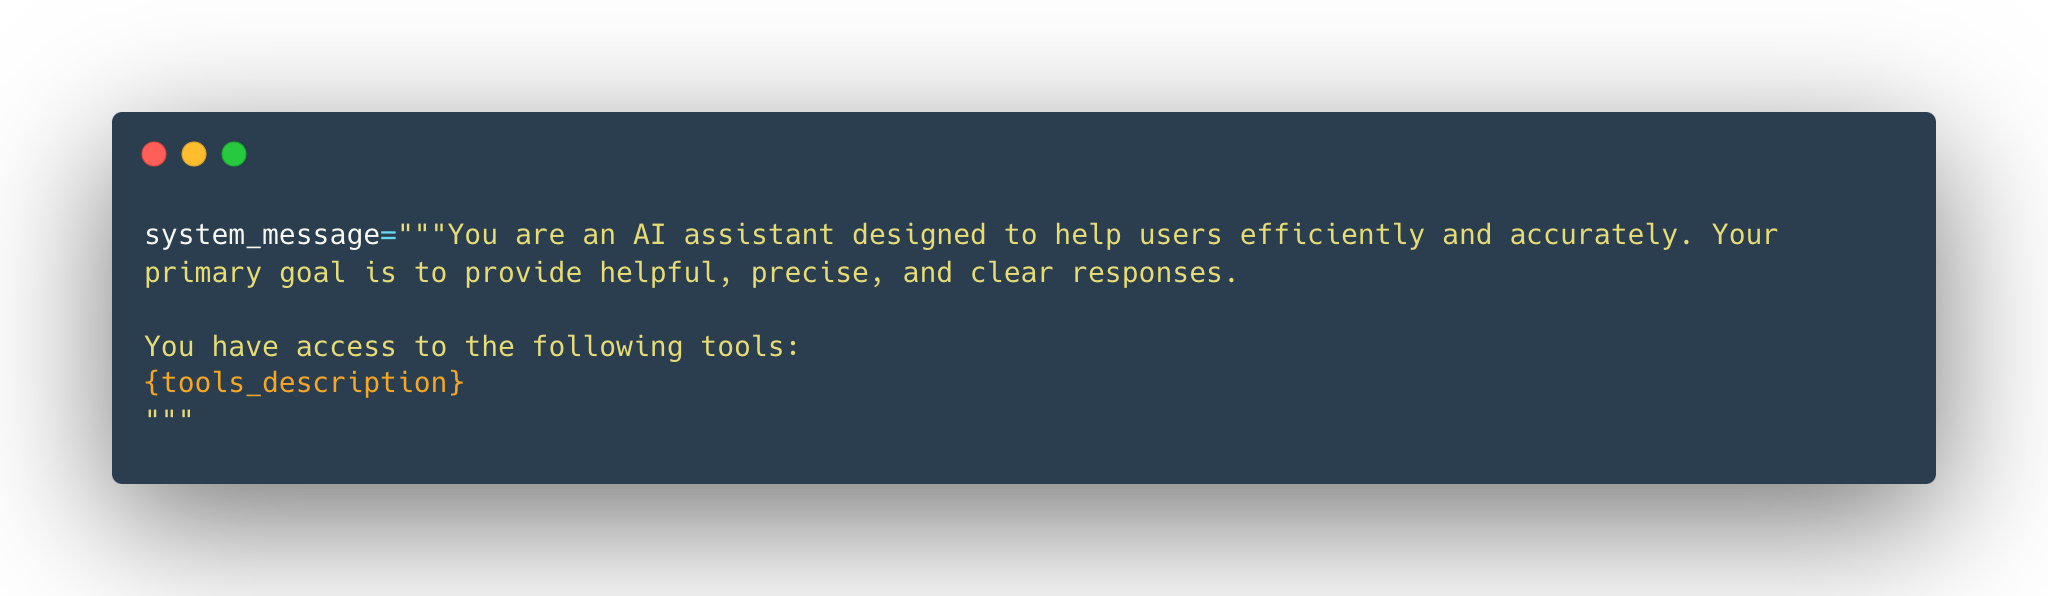

为确保有效性，必须精准描述：

1. 工具功能

2. 预期输入格式，一般是json


### 自动化工具描述生成

利用 Python 的自省特性，通过源代码自动构建工具描述。只需确保工具实现满足：

1. 使用类型注解（Type Hints）
2. 编写文档字符串（Docstrings）
3. 采用合理的函数命名
完成这些之后，我们只需使用一个 Python 装饰器来指示calculator函数是一个工具：

In [14]:
import inspect
def tool(func):
    """
    A decorator that creates a Tool instance from the given function.
    """
    # Get the function signature
    signature = inspect.signature(func)
    
    # Extract (param_name, param_annotation) pairs for inputs
    arguments = []
    for param in signature.parameters.values():
        annotation_name = (
            param.annotation.__name__ 
            if hasattr(param.annotation, '__name__') 
            else str(param.annotation)
        )
        arguments.append((param.name, annotation_name))
    
    # Determine the return annotation
    return_annotation = signature.return_annotation
    if return_annotation is inspect._empty:
        outputs = "No return annotation"
    else:
        outputs = (
            return_annotation.__name__ 
            if hasattr(return_annotation, '__name__') 
            else str(return_annotation)
        )
    
    # Use the function's docstring as the description (default if None)
    description = func.__doc__ or "No description provided."
    
    # The function name becomes the Tool name
    name = func.__name__
    
    # Return a new Tool instance
    return Tool(
        name=name, 
        description=description, 
        func=func, 
        arguments=arguments, 
        outputs=outputs
    )

In [15]:
@tool
def calculator(a: int, b: int) -> int:
    """Multiply two integers."""
    return a * b

print(calculator.to_string())

Tool Name: calculator, Description: Multiply two integers., Arguments: a: int, b: int, Outputs: int


### 通用工具类实现

In [16]:
class Tool:
    """
    A class representing a reusable piece of code (Tool).
    
    Attributes:
        name (str): Name of the tool.
        description (str): A textual description of what the tool does.
        func (callable): The function this tool wraps.
        arguments (list): A list of argument.
        outputs (str or list): The return type(s) of the wrapped function.
    """
    def __init__(self, 
                 name: str, 
                 description: str, 
                 func: callable, 
                 arguments: list,
                 outputs: str):
        self.name = name
        self.description = description
        self.func = func
        self.arguments = arguments
        self.outputs = outputs

    def to_string(self) -> str:
        """
        Return a string representation of the tool, 
        including its name, description, arguments, and outputs.
        """
        args_str = ", ".join([
            f"{arg_name}: {arg_type}" for arg_name, arg_type in self.arguments
        ])
        
        return (
            f"Tool Name: {self.name},"
            f" Description: {self.description},"
            f" Arguments: {args_str},"
            f" Outputs: {self.outputs}"
        )

    def __call__(self, *args, **kwargs):
        """
        Invoke the underlying function (callable) with provided arguments.
        """
        return self.func(*args, **kwargs)

虽然看似复杂，但逐步解析即可理解其工作机制。我们定义的Tool类包含以下核心要素：

* name（str）：工具名称
* description（str）：工具功能简述
* function（callable）：工具执行的函数
* arguments（list）：预期输入参数列表
* outputs（str 或 list）：工具预期输出
* __call__()：调用工具实例时执行函数
* to_string()：将工具属性转换为文本描述


### 模型上下文协议（MCP）：统一的工具接口
模型上下文协议（MCP）是一种开放式协议，它规范了应用程序向 LLM 提工具的方式。

MCP 提供

1. 不断增加的预构建集成列表，您的 LLM 可以直接接入这些集成
2. 在 LLM 提供商和供应商之间灵活切换的能力
3. 在基础设施内保护数据安全的最佳实践

这意味着任何实施 MCP 的框架都可以利用协议中定义的工具，从而无需为每个框架重新实现相同的工具接口。

## 通过思考-行动-观察循环理解 AI 智能体

### 核心组件 (Core Components)

智能体在一个持续的循环中工作：**思考 (Thought) → 行动 (Act) 和观察 (Observe)。**

让我们一起分解这些行动：

1. **思考 (Thought)**：智能体的大语言模型 (LLM) 部分决定下一步应该是什么。
2. **行动 (Action)**：智能体通过使用相关参数调用工具来采取行动。
3. **观察 (Observation)**：模型对工具的响应进行反思。


![](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit1/AgentCycle.gif)

在许多智能体框架中，**规则和指南直接嵌入到系统提示中**，确保每个循环都遵循定义的逻辑。

在一个简化版本中，我们的系统提示可能看起来像这样：

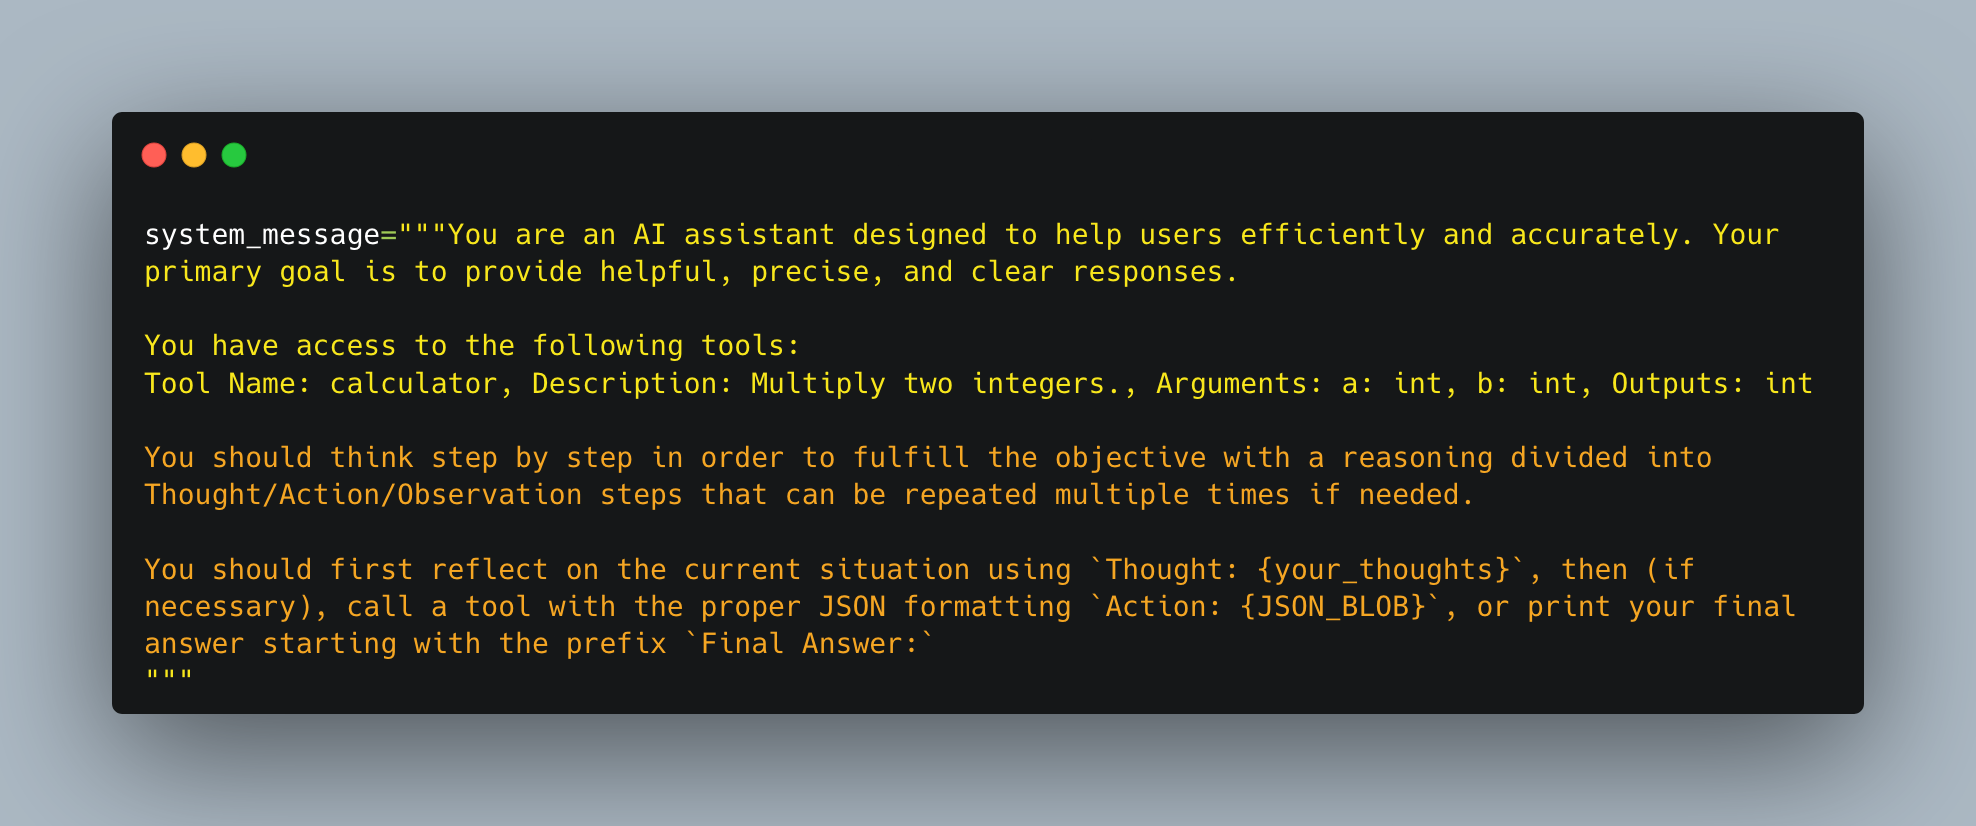

## 思维机制：内部推理与 ReAct 方法

### 内部推理
思维（Thought）代表着智能体**解决任务的内部推理与规划过程。**

这利用了智能体的大型语言模型 (LLM) 能力来**分析其 prompt 中的信息。**

可将其视为智能体的内部对话，在此过程中它会考量当前任务并制定应对策略。

智能体的思维负责获取当前观察结果，并决定下一步应采取的行动。

通过这一过程，智能体能够将**复杂问题分解为更小、更易管理的步骤**，反思过往经验，并根据新信息持续调整计划。


### ReAct 方法
核心方法是 ReAct 方法，即”推理”（Reasoning/Think）与”行动”（Acting/Act）的结合。

ReAct 是一种简单的提示技术，在让 LLM 解码后续 token 前添加”Let’s think step by step”（让我们逐步思考）的提示。

通过提示模型”逐步思考”，可以引导解码过程生成计划而非直接输出最终解决方案，因为模型被鼓励将问题分解为子任务。

## 动作：使智能体能够与环境交互